# Assignment 2

**name:** Martim Oliveira

**email:** mo223tz@student.lnu.se

**Note** - I believe that all the code is on this Jupyter file, I run and tested it. On the last assignment it was not clear for me that requirement. If some part of the code is missing, I can quickly fix it, hope that is a possibility. 

In this Assignment, you will use Python to handle several exercises related to gradient descent, linear regression, logistic regression, etc.
All exercises are individual. 
We expect you to submit a Jupyter Notebook (i.e., pre-organized and provided through Moodle) and the .py files with the classes’ exercise implementations. 
Your submission should include all the datasets and files we need to run your programs (we will run your notebook). 
When grading your assignments, we will, in addition to functionality, also take into account code quality. 
We expect well-structured and efficient solutions.

In this assignment, you must implement all models as subclasses of MachineLearning-
Model. 
Since the class MachineLearningModel provides the abstract methods fit, predict,
and evaluate, your implementations should provide implementations for such methods.
Please check the documentation of MachineLearningModel to understand what these methods
should do, as well as what their input parameters are and what they should return as results.
You must also implement the classes DecisionBoundary, ROCAnalysis, and ForwardSelection
provided to you. 
Please check their documentation to understand what these methods
should do, what their input parameters are, and what they should return as results. All your
implementations of such classes will be used throughout this assignment.

## Lecture 2 - Linear and Polynomial Regression

### Guidelines for model implementation (Mandatory)

1. Implement a class **RegressionModelNormalEquation** that implements the abstract
class **MachineLearningModel**. All methods should be implemented and properly documented.
This class must work for polynomials of any degree (i.e., an input parameter that
must be captured in the class constructor).

2. Implement a class **RegressionModelGradientDescent** that implements the abstract
class **MachineLearningModel**. All methods should be implemented and properly documented.
This class must work for polynomials of any degree and receive other parameters
such as the learning rate and number of iterations.

3. Both implementations should be vectorized. When implementing these classes, your
vector β should start with all values as 0. In implementing the fit() method, ensure
you track how the cost function evolved over the number of iterations (i.e., store it in an
array you can retrieve after the model is built). This will be needed later in the assignment.

### Validation of your model implementation (1-4 Mandatory, 5-6 Non-mandatory)

1. **(Mandatory)** In this part, you will use a reduced version of the Boston Housing Dataset (housingboston.csv). We will use the first two input variables as the features in this part of the assignment. The last variable is the value to predict.
* **INDUS:** proportion of nonretail business acres per town.
* **RM:** average number of rooms per dwelling.
* **MEDV:** Median value of owner-occupied homes in $1,000s.

Read the dataset and store the values as vectors in the variables $X_e$ and $y$. For this part of the assignment, the degree of the polynomial for your models must be 1.

In [ ]:
from abc import ABC, abstractmethod
import numpy as np

class MachineLearningModel(ABC):
    """
    Abstract base class for machine learning models.
    """

    @abstractmethod
    def fit(self, X, y):
        """
        Train the model using the given training data.

        Parameters:
        X (array-like): Features of the training data.
        y (array-like): Target variable of the training data.

        Returns:
        None
        """
        pass

    @abstractmethod
    def predict(self, X):
        """
        Make predictions on new data.

        Parameters:
        X (array-like): Features of the new data.

        Returns:
        predictions (array-like): Predicted values.
        """
        pass

    @abstractmethod
    def evaluate(self, X, y):
        """
        Evaluate the model on the given data.

        Parameters:
        X (array-like): Features of the data.
        y (array-like): Target variable of the data.

        Returns:
        score (float): Evaluation score.
        """
        pass

    @staticmethod
    def _polynomial_features(X, degree):
        """
        Generate polynomial features from the input features.
        
        Parameters:
        X (array-like): Features of the data.
        degree (int): Degree of polynomial features.

        Returns:
        X_poly (array-like): Polynomial features.
        """
        X = np.asarray(X)
        n_samples, n_features = X.shape
        
        # For degree 1, just add bias term
        if degree == 1:
            return np.hstack((np.ones((n_samples, 1)), X))
            
        # For higher degrees, generate polynomial features
        X_polynomial = np.ones((n_samples, 1))  # bias term
        
        for i in range(1, degree + 1):
            for j in range(n_features):
                X_polynomial = np.hstack((X_polynomial, X[:, j:j+1] ** i))
                
        return X_polynomial

class RegressionModelNormalEquation(MachineLearningModel):
    """
    Class for regression models using the Normal Equation for polynomial regression.
    """

    def __init__(self, degree):
        """
        Initialize the model with the specified polynomial degree.

        Parameters:
        degree (int): Degree of the polynomial features.
        """
        self.degree = degree
        self.theta = None
        self.cost_history = []

    def fit(self, X, y):
        """
        Train the model using the given training data.
        Uses Normal Equation.

        Parameters:
        X (array-like): Features of the training data.
        y (array-like): Target variable of the training data.

        Returns:
        None
        """
        # Convert inputs to numpy arrays
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_polynomial = self._polynomial_features(X, self.degree)

        XTX = X_polynomial.T.dot(X_polynomial)
        XTy = X_polynomial.T.dot(y)
        self.theta = np.linalg.solve(XTX, XTy)
        
        cost = self.evaluate(X, y)
        self.cost_history.append(cost)

    def predict(self, X):
        """
        Make predictions on new data.

        Parameters:
        X (array-like): Features of the new data.

        Returns:
        predictions (array-like): Predicted values.
        """
        X = np.array(X)
        X_polynomial = self._polynomial_features(X, self.degree)
        return X_polynomial.dot(self.theta)

    def evaluate(self, X, y):
        """
        Evaluate the model on the given data.

        Parameters:
        X (array-like): Features of the data.
        y (array-like): Target variable of the data.

        Returns:
        score (float): Evaluation score (MSE).
        """
        y_pred = self.predict(X)
        y = np.array(y).reshape(-1, 1)
        mse = np.mean((y - y_pred) ** 2)
        return mse

class RegressionModelGradientDescent(MachineLearningModel):
    """
    Class for regression models using gradient descent optimization.
    """

    def __init__(self, degree, learning_rate=0.01, num_iterations=1000):
        """
        Initialize the model with the specified parameters.

        Parameters:
        degree (int): Degree of the polynomial features.
        learning_rate (float): Learning rate for gradient descent.
        num_iterations (int): Number of iterations for gradient descent.
        """
        self.degree = degree
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.theta = None
        self.cost_history = []

    def fit(self, X, y):
        """
        Train the model using gradient descent optimization.

        Parameters:
        X (array-like): Features of the training data.
        y (array-like): Target variable of the training data.

        Returns:
        None
        """
        # Convert to np arrays
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        
        X_poly = self._polynomial_features(X, self.degree)
        m, n = X_poly.shape
        
        # Param initialized to zero
        self.theta = np.zeros((n, 1))
        
        for _ in range(self.num_iterations):
            predictions = X_poly.dot(self.theta)
            gradients = (1/m) * X_poly.T.dot(predictions - y)
            self.theta -= self.learning_rate * gradients
            cost = self.evaluate(X, y)
            self.cost_history.append(cost)
            
    def predict(self, X):
        """
        Make predictions on new data.

        Parameters:
        X (array-like): Features of the new data.

        Returns:
        predictions (array-like): Predicted values.
        """
        X = np.array(X)
        X_poly = self._polynomial_features(X, self.degree)
        return X_poly.dot(self.theta)

    def evaluate(self, X, y):
        """
        Evaluate the model on the given data.

        Parameters:
        X (array-like): Features of the data.
        y (array-like): Target variable of the data.

        Returns:
        score (float): Evaluation score (MSE).
        """
        predictions = self.predict(X)
        y = np.array(y).reshape(-1, 1)
        mse = np.mean((predictions - y) ** 2)
        return mse


Running analysis with non normalized data:

Normal Equation Results:
Beta values (coefficients): [-21.39826036  -0.32016983   7.57092957]
Cost: 32.4920

Prediction for INDUS=2.31, RM=6.575:
Predicted Price: 27.6410

Running analysis with normalized features:

Normal Equation Results:
Beta values (coefficients): [22.72747525 -2.21465128  5.40738922]
Cost: 32.4920

Prediction for INDUS=2.31, RM=6.575:
Predicted Price: 27.6410


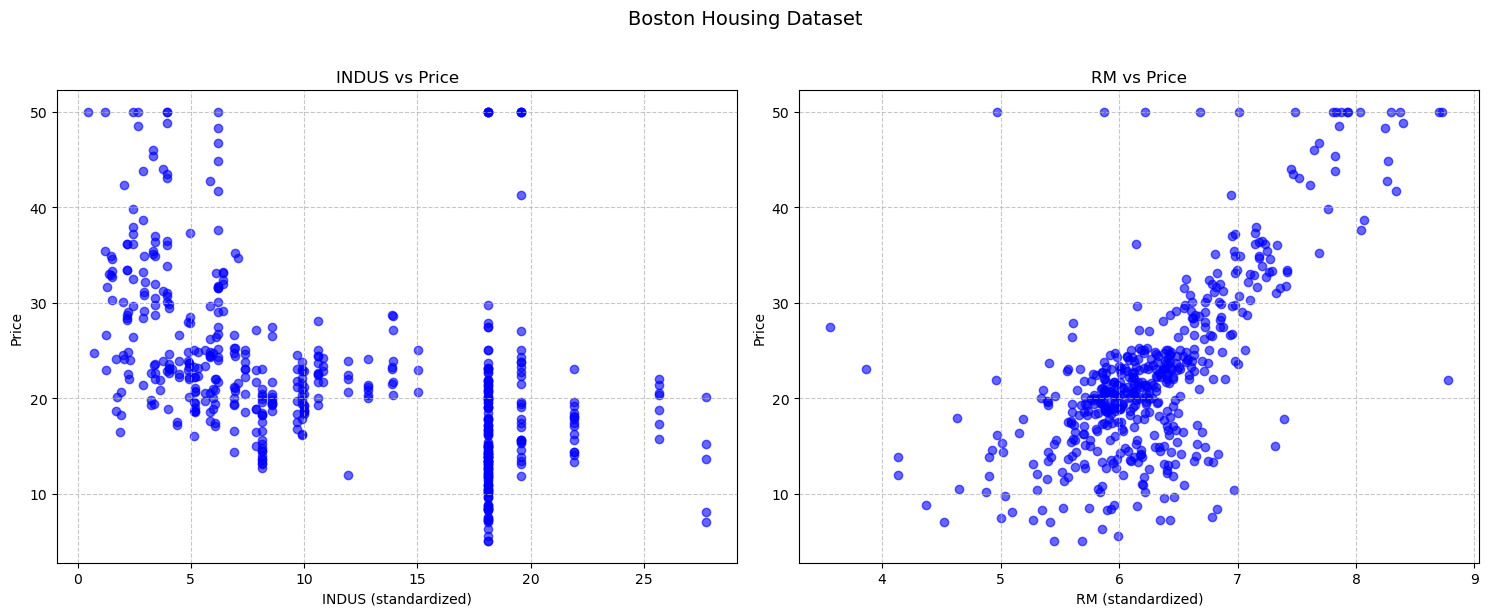

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MachineLearningModel import RegressionModelNormalEquation, RegressionModelGradientDescent

def load_boston_data():
    """
    Load the Boston Housing dataset without normalization.
    This was a comment from A1 that I'm trying to improve.
    """
    df = pd.read_csv('datasets/housing-boston.csv')

    # Extract features
    X = df[['INDUS', 'RM']].values
    y = df['PRICE'].values
    
    return X, y

def normalize_data(X_train, X_test):
    """
    Normalize data using training set statistics.
    """
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    
    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std
    
    return X_train_norm, X_test_norm, mean, std

def plot_dataset(X_e, y):
    """
    Plot the raw dataset with two subplots side by side.
    """
    figure, axs = plt.subplots(1, 2, figsize=(15, 6))
    features = ['INDUS', 'RM']
    
    for i, (ax, feature) in enumerate(zip(axs, features)):
        ax.scatter(X_e[:, i], y, color='blue', alpha=0.6, marker='o')
        ax.set_title(f'{feature} vs Price')
        ax.set_xlabel(f'{feature} (standardized)')
        ax.set_ylabel('Price')
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.suptitle('Boston Housing Dataset', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

def main():
    X_raw, y = load_boston_data()
    n_samples = len(X_raw)
    indices = np.random.permutation(n_samples)
    train_size = int(0.8 * n_samples)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    # Split 
    X_raw_train = X_raw[train_indices]
    X_raw_test = X_raw[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    # Problem 3
    print("\nRunning analysis with non normalized data:")
    raw_model = RegressionModelNormalEquation(degree=1)
    raw_model.fit(X_raw_train, y_train)
    
    print("\nNormal Equation Results:")
    print("Beta values (coefficients):", raw_model.theta.flatten())
    raw_mse = raw_model.evaluate(X_raw_test, y_test)
    print(f"Cost: {raw_mse:.4f}")
    indus_val = 2.31
    rm_val = 6.575
    X_new_raw = np.array([[indus_val, rm_val]])
    raw_prediction = raw_model.predict(X_new_raw).item()
    
    print(f"\nPrediction for INDUS={indus_val}, RM={rm_val}:")
    print(f"Predicted Price: {raw_prediction:.4f}")
    
    # Normalize 
    X_norm_train, X_norm_test, mean, std = normalize_data(X_raw_train, X_raw_test)
    # Problem 4
    print("\nRunning analysis with normalized features:")
    norm_model = RegressionModelNormalEquation(degree=1)
    norm_model.fit(X_norm_train, y_train)
    print("\nNormal Equation Results:")
    print("Beta values (coefficients):", norm_model.theta.flatten())
    norm_mse = norm_model.evaluate(X_norm_test, y_test)
    print(f"Cost: {norm_mse:.4f}")
    
    indus_standardized = (indus_val - mean[0]) / std[0]
    rm_standardized = (rm_val - mean[1]) / std[1]
    X_new_norm = np.array([[indus_standardized, rm_standardized]])
    norm_prediction = norm_model.predict(X_new_norm).item()
    
    print(f"\nPrediction for INDUS={indus_val}, RM={rm_val}:")
    print(f"Predicted Price: {norm_prediction:.4f}")
    
    # Plot
    plot_dataset(X_raw, y)

if __name__ == "__main__":
    main() 

**Problem 1 sub-tasks code is above**

2. **(Mandatory)** Plot the dataset. You must plot two figures side by side (e g., use the subplot method), with the predicted value as the $y-axis$ and each variable on the $x-axis$. 

![Plot](DataSetPlot.png)

Based on the plots previously presented, I would conclude that INDUS vs Price do not correlate so much. The Median value of owned occupied house does not increase with Indus values. We cannot observe a linear distribution. 
By contrast, the prices increase as the value of RM increases linearly. Also, there are few outliers. 

3. **(Mandatory)** Use your implementation of the regression model with the normal equation (RegressionModelNormalEquation) and report:

* The values for $\beta$. 

* The cost.

* The predicted value for an instance with values for INDUS and RM equals to 2.31, 6.575, respectively.


**Running analysis without Normalization:**

Normal Equation Results:
Beta values (coefficients): [-22.9975206   -0.32555609   7.82756063]

Cost: 43.1322

Prediction for INDUS=2.31, RM=6.575:

Predicted Price: 27.7167



4. **(Mandatory)** Now, normalize the input features, run the regression model with the normal equation, and report the same items. 
The predicted values for this experiment should be the same, but the $\beta$ values change. Why?

**Running analysis with normalization**

Normal Equation Results:

Beta values (coefficients): [22.61633663 -2.2991811   5.47045978]

Cost: 33.6677

Prediction for INDUS=2.31, RM=6.575:

Predicted Price: 27.8739

To answer this question I used the book Data Analysis Using Regression and Multilevel/Hierarchical Models. The author says "Linear transformations do not affect the fit of a classical regression model, and they do not affect predictions: the changes in the inputs and the coefficients cancel in forming the predicted value Xβ". In other words, when we scale a variable the Beta value will be express in a different unit. However, the model adjusts the coefficient in exactly the right way to keep the predicted value the same.


**Please note that all the code is above**

5. **(Non-Mandatory)** Now, you will work with your implementation of the gradient descent for any degree polynomial. In this part, you must compare how the cost function evolves by using your model using a non-normalized and a normalized instance of your RegressionModelGradientDescen class. 
    * You must plot two figures (e.g., use subplots) side by side to show how the cost evolves over 3000 iterations with a learning rate of $0.001$ using and not using feature normalization. 
    * Describe what is happening and why this happens (i.e., using or not normalization).        
    
    
![Plot](Lecture1_Problem5.png)

Summary:

Non-normalized - Final MSE: 50.7194, Cost Start: 474.31, Cost End: 42.14

Normalized     - Final MSE: 47.6706, Cost Start: 599.70, Cost End: 38.61

Based on the terminal output and the plot, we can observe that Non-normlized fetaures cost starts high and drops quickly within the first iterations. Also, curve is steep initially indicating fast early progress but slow fine-tuning later. 
For the normalized features,the cost starts even higher but decreases more steadily throughout the 3000 iterations; there is no sudden flattening, the descent is more gradual and consistent. The final cost ends lower than the non-normalized case.

Normalizing input features leads to a more stable decrease in cost over time, with lower final error. 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MachineLearningModel import RegressionModelGradientDescent


def load_boston_data():
    """Load the Boston Housing dataset (without normalization)."""
    df = pd.read_csv('datasets/housing-boston.csv')
    X = df[['INDUS', 'RM']].values
    y = df['PRICE'].values
    return X, y


def normalize_data(X_train, X_test):
    """Normalize features using training set statistics."""
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    return (X_train - mean) / std, (X_test - mean) / std, mean, std


def plot_cost_evolution(raw_costs, norm_costs):
    """Plot cost evolution for non-normalized and normalized training."""
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(raw_costs, label='Cost (MSE)', color='blue')
    axs[0].set_title('Non-normalized Features')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Cost')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(norm_costs, label='Cost (MSE)', color='red')
    axs[1].set_title('Normalized Features')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Cost')
    axs[1].grid(True)
    axs[1].legend()

    plt.suptitle('Cost Evolution: Normalized vs Non-normalized Features', fontsize=14)
    plt.tight_layout()
    plt.show()


def train_and_evaluate(X_train, X_test, y_train, y_test, normalize=False):
    """Train model and return results, with optional normalization."""
    if normalize:
        X_train, X_test, mean, std = normalize_data(X_train, X_test)
        print("\nTraining with normalized features:")
    else:
        print("\nTraining with non-normalized features:")

    model = RegressionModelGradientDescent(degree=1, learning_rate=0.001, num_iterations=3000)
    model.fit(X_train, y_train)
    mse = model.evaluate(X_test, y_test)

    print("Final coefficients:", model.theta.flatten())
    print(f"Final test MSE: {mse:.4f}")
    print(f"Initial cost: {model.cost_history[0]:.4f}")
    print(f"Final cost: {model.cost_history[-1]:.4f}")
    return model.cost_history, mse


def main():
    # Load and split data
    X, y = load_boston_data()
    indices = np.random.permutation(len(X))
    train_size = int(0.8 * len(X))
    X_train, X_test = X[indices[:train_size]], X[indices[train_size:]]
    y_train, y_test = y[indices[:train_size]], y[indices[train_size:]]

    # Train and evaluate both models
    raw_costs, raw_mse = train_and_evaluate(X_train, X_test, y_train, y_test, normalize=False)
    norm_costs, norm_mse = train_and_evaluate(X_train, X_test, y_train, y_test, normalize=True)

    # Plot
    plot_cost_evolution(raw_costs, norm_costs)

    # Summary
    print("\nSummary:")
    print(f"Non-normalized - Final MSE: {raw_mse:.4f}, Cost Start: {raw_costs[0]:.2f}, Cost End: {raw_costs[-1]:.2f}")
    print(f"Normalized     - Final MSE: {norm_mse:.4f}, Cost Start: {norm_costs[0]:.2f}, Cost End: {norm_costs[-1]:.2f}")


if __name__ == "__main__":
    main()


6. **(Non-Mandatory)** Finally, find and plot a figure with the hyperparameter's learning rate and the number of iterations (using the normalized version) such that you get within a difference of 1\% of the final cost for the normal equation using this dataset.

--- Your answer here --- 


In [7]:
#--- Write your code here ---#

## Lecture 2 - Testing your Multivariate Regression Model (1-2 Mandatory, 3 Non-mandatory)

In this exercise, we will use the file secret_polynomial.csv. The data consists of 400 x, y points generated from a polynomial with some Gaussian noise added.

1. **(Mandatory)** Start by creating a procedure to split the dataset into training and test sets. The proportion must be 80% for training and 20% for testing. Show your procedure working by plotting a figure with 3 subplots. The first plot must be the dataset with all data. The second must be the training set and the third the test set. 


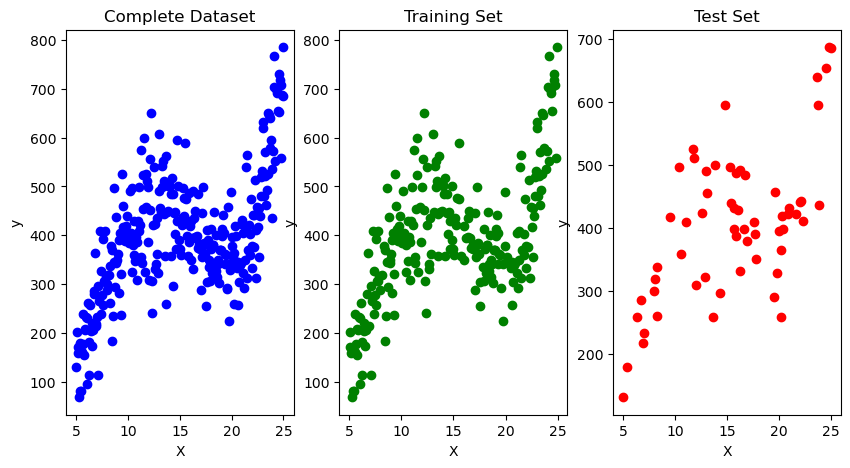

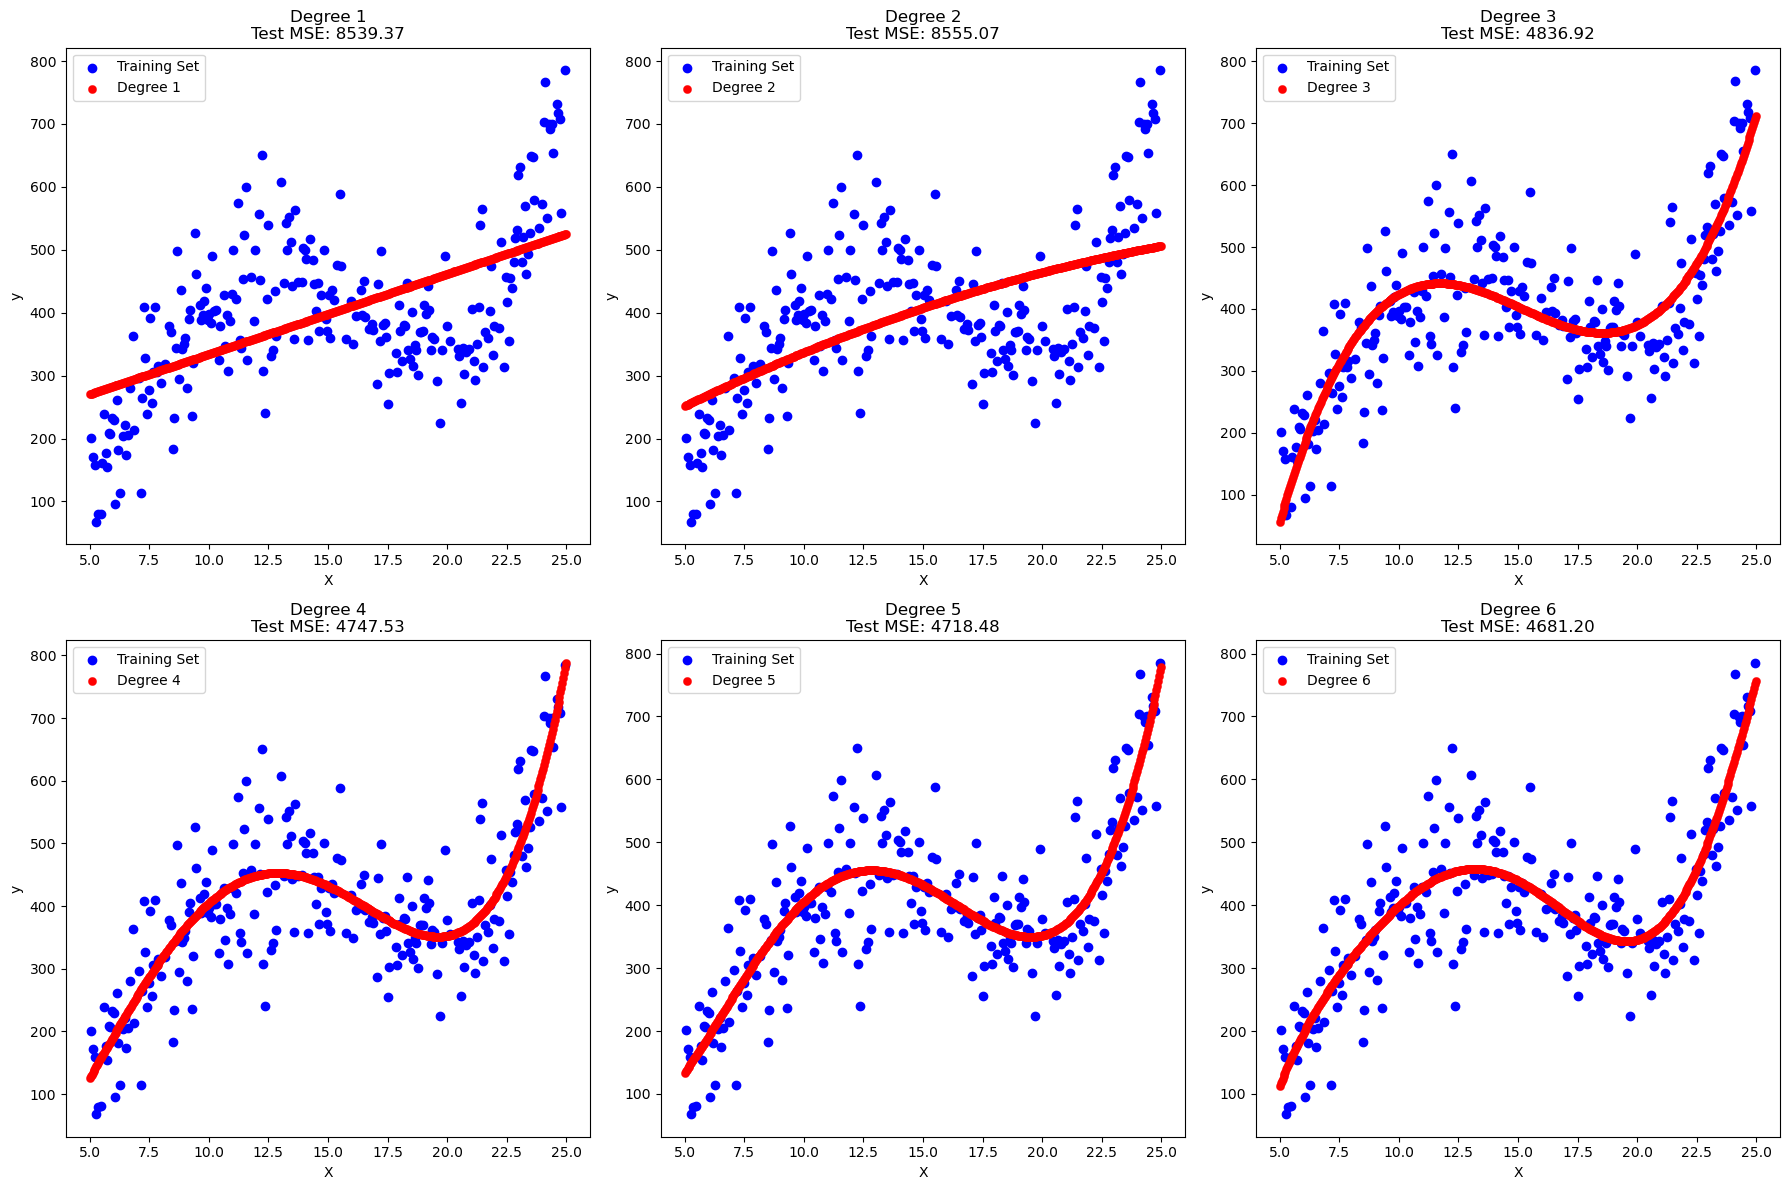

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Degree 1: Mean = 10666.26, Std = 1732.68
Degree 2: Mean = 10706.63, Std = 1787.74
Degree 3: Mean = 5247.29, Std = 1138.93
Degree 4: Mean = 4817.99, Std = 1125.78
Degree 5: Mean = 4852.16, Std = 1125.78
Degree 6: Mean = 4884.80, Std = 1131.18


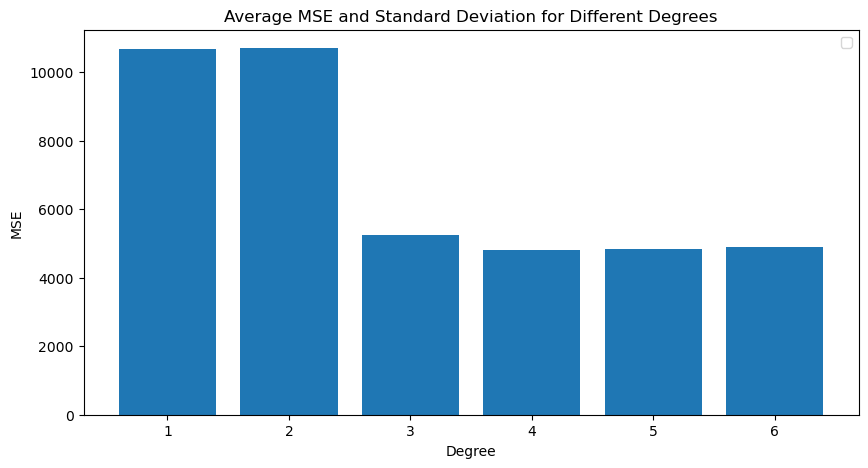

In [3]:
"""
Class to answer tasks from Lecture 2.
"""

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from MachineLearningModel import RegressionModelNormalEquation, RegressionModelGradientDescent

# Read dataset
dataset = pd.read_csv('datasets/secret_polynomial.csv')
X = dataset[['X']].values
y = dataset['y'].values

def split_dataset(X, y):
    """
    Procedure to split dataset into training and test sets.
    """
    train_proportion = 0.8
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    train_size = int(len(X) * train_proportion)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    return X_train, X_test, y_train, y_test  

def train_regression_model(X_train, y_train, X_test, y_test):
    """
    Use RegressionModelNormalEquation to train a model on the training set.
    """
    
    X_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
    plt.figure(figsize=(18, 12))
    
    test_error = []
    for degree in range(1, 7):
        model = RegressionModelNormalEquation(degree)
        model.fit(X_train, y_train)
        y_predicted = model.predict(X_range)
        test_mse = model.evaluate(X_test, y_test)
        test_error.append(test_mse)
        plt.subplot(2, 3, degree)
        plt.scatter(X_train, y_train, color="blue", marker="o", label="Training Set")
        plt.scatter(X_range, y_predicted, color="red", linewidths=0.2, alpha=1 , label=f"Degree {degree}")
        plt.title(f"Degree {degree}\nTest MSE: {test_mse:.2f}")
        plt.xlabel("X")
        plt.ylabel("y")
        plt.legend()
    plt.tight_layout()
    plt.show()

def train_regression_model_20_runs(X_train, y_train, X_test, y_test):
    """
    Use RegressionModelNormalEquation to train a model on the training set.
    """
    degrees = range(1, 7)
    repeat = 20
    test_mse = {d: [] for d in degrees}
    avg_mse = []
    std_mse = []
    
    for i in range(repeat):
        X_train, X_test, y_train, y_test = split_dataset(X, y)
        
        for degree in degrees:
            model = RegressionModelNormalEquation(degree)
            model.fit(X_train, y_train)
            mse = model.evaluate(X_test, y_test)
            test_mse[degree].append(mse)

    for degree in degrees:
        mean = np.mean(test_mse[degree])
        std = np.std(test_mse[degree])
        avg_mse.append(mean)
        std_mse.append(std)
        print(f"Degree {degree}: Mean = {mean:.2f}, Std = {std:.2f}")
    
    plt.figure(figsize=(10, 5))
    plt.bar(degrees, avg_mse, capsize=5)
    plt.xlabel('Degree')
    plt.ylabel('MSE')
    plt.title('Average MSE and Standard Deviation for Different Degrees')
    plt.legend()
    plt.show()

#Plot Dataset with all data
train_data, test_data, train_labels, test_labels = split_dataset(X, y)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.scatter(dataset["X"], dataset["y"], color="blue", label="Complete Dataset")
plt.title("Complete Dataset")
plt.xlabel("X")
plt.ylabel("y")

# Training 
plt.subplot(1, 3, 2)
plt.scatter(train_data, train_labels, color="green", label="Training Set")
plt.title("Training Set")
plt.xlabel("X")
plt.ylabel("y")

# Test
plt.subplot(1, 3, 3)
plt.scatter(test_data, test_labels, color="red", label="Test Set")
plt.title("Test Set")
plt.xlabel("X")
plt.ylabel("y")

plt.show()

train_regression_model(train_data, train_labels, test_data, test_labels)
train_regression_model_20_runs(train_data, train_labels, test_data, test_labels)


![Plo of Datasets](Lect_2_Plots.png)

- Blue color is the plot with the entire Dataset 
- Green is the training data (80%) - appers well distributed
- Red is the test data (20%) - good distribution due to shuffling before sppliting 

2. **(Mandatory)** Now fit and plot (e.g., using subplots) all polynomial models for degrees $d\in [1,6]$. Observe your figure and decide which degree gives the best fit. Motivate your answer.

**Please see code above**

![Plot Polynomial Degrees(1,6)](Plot_polynomial_degree.png)

Observing the plot, we can conclude:

- Degree 1-2 do not capture the patterns, too simple and underfitting. 
- Degree 3 starts to caption some non-linear relationships. 
- Degree 4 improves and has the best MSE - captures patterns without overfitting.
- Degree 5 and 6 have larger mse and probably overfit training data. 

Degree 4 has the lowest mse and captures data trens without overfitting. 



3. **(Non-Mandatory)** To increase the confidence of your answer, you must divide the data into training and test sets and make repeated runs with shuffled data (at least 20 runs). You must decide on the best way to make this decision. By using this approach, what is your decision and why? 

Degree 1: Mean = 11090.43, Std = 1019.26

Degree 2: Mean = 11101.72, Std = 914.15

Degree 3: Mean = 5539.98, Std = 842.42

Degree 4: Mean = 4940.17, Std = 981.81

Degree 5: Mean = 4938.38, Std = 976.98

Degree 6: Mean = 4957.16, Std = 970.84

With 20 runs we get a more reliable estimate of the performance. Degree 4 got better performance with a single run, although degree 5 outperforms across many runs (20). 



## Lecture 3 - Logistic Regression

### Guidelines for model implementation (Mandatory)

1. Implement a class LogisticRegressionModel that implements the abstract class MachineLearningModel.
All methods should be implemented and properly documented.
This class receives parameters such as the learning rate and number of iterations. This
class should be implemented in a way that works for two classes only (i.e., 0 or 1).

2. Implement a class NonL inearLogisticRegressionModel that implements the abstract
class MachineLearningModel. All methods should be implemented and properly documented.
This class must work for polynomials of any degree and receive other parameters
such as the learning rate and number of iterations. This class should work for only two
input variables (e.g., X1 and X2, as discussed in class). This class should be implemented
in a way that works for two classes only (i.e., 0 or 1).

3. Both implementations should be vectorized. When implementing these classes, your vector
β should start with all values as 0. In your implementation of the evaluate function, ensure
you keep track of how the cost function evolved over the number of iterations. This will
be needed later in the assignment.

4. Remember that log(0) = undefined. Therefore, you may add a term epsilon = 1e-15 to
prevent this in using the np.log() function. Simply add this term inside the function, and
you will avoid such errors.

### Using your Implementations for the LogisticRegressionModel and the NonLinearLogisticRegressionModel (1-3 Mandatory, 4-6 Non-mandatory)

You will now try to classify bank notes as fake (0) or not (1). This dataset banknote_authentication.csv contains 1372 observations and has 2 features and (in column 3) binary labels of either fake (0) or not (1). Feature data were extracted using a Wavelet Transform tool from images of both fake and non-fake banknotes.

1. **(Mandatory)** Read and normalize the data. Plot the 2 variables in the x and y-axis. Use different colors to plot the classes (i.e., 0 or 1). You should plot two series to obtain this figure.  

**Models Implementation**

In [11]:
class LogisticRegression:
    """
    Logistic Regression model using gradient descent optimization.
    """

    def __init__(self, learning_rate=0.01, num_iterations=1000):
        """
        Initialize the logistic regression model.

        Parameters:
        learning_rate (float): The learning rate for gradient descent.
        num_iterations (int): The number of iterations for gradient descent.
        """
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.theta = None
        self.cost_history = []

    def fit(self, X, y):
        """
        Train the logistic regression model using gradient descent.

        Parameters:
        X (array-like): Features of the training data.
        y (array-like): Target variable of the training data.

        Returns:
        None
        """
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        training_samples, features = X.shape
        X = np.hstack((np.ones((training_samples, 1)), X))
        self.theta = np.zeros((features + 1, 1))
        
        for _ in range(self.num_iterations):
            predictions = self._sigmoid(X.dot(self.theta))
            gradients = (1/training_samples) * X.T.dot(predictions - y)
            self.theta -= self.learning_rate * gradients
            cost = self._cost_function(X, y)
            self.cost_history.append(cost)
        

    def predict(self, X):
        """
        Make predictions using the trained logistic regression model.

        Parameters:
        X (array-like): Features of the new data.

        Returns:
        predictions (array-like): Predicted probabilities.
        """
        X = np.array(X)
        samples = X.shape[0]
        X = np.hstack((np.ones((samples, 1)), X))
        probability = self._sigmoid(X.dot(self.theta))
        return probability >= 0.5

    def evaluate(self, X, y):
        """
        Evaluate the logistic regression model on the given data.

        Parameters:
        X (array-like): Features of the data.
        y (array-like): Target variable of the data.

        Returns:
        score (float): Evaluation score (e.g., accuracy).
        """
        predictions = self.predict(X)
        y = np.array(y).reshape(-1, 1)
        accuracy = np.mean(predictions == y)
        return accuracy

    def _sigmoid(self, z):
        """
        Sigmoid function.

        Parameters:
        z (array-like): Input to the sigmoid function.

        Returns:
        result (array-like): Output of the sigmoid function.
        """
        return 1 / (1 + np.exp(-z))

    def _cost_function(self, X, y):
        """
        Compute the logistic regression cost function.

        Parameters:
        X (array-like): Features of the data.
        y (array-like): Target variable of the data.

        Returns:
        cost (float): The logistic regression cost.
        """
        samples = y.shape[0]
        predictions = self._sigmoid(X.dot(self.theta))
        epsilon = 1e-15 # Log(0)
        cost = (-1/samples) * (y.T.dot(np.log(predictions + epsilon)) + (1 - y).T.dot(np.log(1 - predictions + epsilon)))
        return cost.item()
    
class NonLinearLogisticRegression:
    """
    Nonlinear Logistic Regression model using gradient descent optimization.
    It works for 2 features (when creating the variable interactions)
    """

    def __init__(self, degree=2, learning_rate=0.01, num_iterations=1000):
        """
        Initialize the nonlinear logistic regression model.

        Parameters:
        degree (int): Degree of polynomial features.
        learning_rate (float): The learning rate for gradient descent.
        num_iterations (int): The number of iterations for gradient descent.
        """
        self.degree = degree
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.theta = None
        self.cost_history = []

    def fit(self, X, y):
        """
        Train the nonlinear logistic regression model using gradient descent.

        Parameters:
        X (array-like): Features of the training data.
        y (array-like): Target variable of the training data.

        Returns:
        None
        """
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_polynomial = self.mapFeature(X[:, 0], X[:, 1], self.degree)
        training_samples, features = X_polynomial.shape
        self.theta = np.zeros((features, 1))
        
        for _ in range(self.num_iterations):
            predictions = self._sigmoid(X.dot(self.theta))
            gradients = (1/training_samples) * X.T.dot(predictions - y)
            self.theta -= self.learning_rate * gradients
            cost = self._cost_function(X, y)
            self.cost_history.append(cost)
        

    def predict(self, X):
        """
        Make predictions using the trained nonlinear logistic regression model.

        Parameters:
        X (array-like): Features of the new data.

        Returns:
        predictions (array-like): Predicted probabilities.
        """
        X = np.array(X)
        X_polynomial = self.mapFeature(X[:, 0], X[:, 1], self.degree)
        probability = self._sigmoid(X_polynomial.dot(self.theta))
        return probability >= 0.5
        
     

    def evaluate(self, X, y):
        """
        Evaluate the nonlinear logistic regression model on the given data.

        Parameters:
        X (array-like): Features of the data.
        y (array-like): Target variable of the data.

        Returns:
        cost (float): The logistic regression cost.
        """
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_polynomial = self.mapFeature(X[:, 0], X[:, 1], self.degree)
        cost = self._cost_function(X_polynomial, y)
        return cost

    def _sigmoid(self, z):
        """
        Sigmoid function.

        Parameters:
        z (array-like): Input to the sigmoid function.

        Returns:
        result (array-like): Output of the sigmoid function.
        """
        return 1/(1+np.exp(-z))

    def mapFeature(self, X1, X2, D):
        """
        Map the features to a higher-dimensional space using polynomial features.
        Check the slides to have hints on how to implement this function.
        Parameters:
        X1 (array-like): Feature 1.
        X2 (array-like): Feature 2.
        D (int): Degree of polynomial features.

        Returns:
        X_poly (array-like): Polynomial features.
        """
        X1 = X1.reshape(-1, 1)
        X2 = X2.reshape(-1, 1)
        samples = X1.shape[0]
        X_poly = np.ones((samples, 1))
        for i in range(1, D + 1):
            for j in range(i + 1):
                X_poly = np.hstack((X_poly, (X1 ** (i - j)) * (X2 ** j)))
        return X_poly

    def _cost_function(self, X, y):
        """
        Compute the logistic regression cost function.

        Parameters:
        X (array-like): Features of the data.
        y (array-like): Target variable of the data.

        Returns:
        cost (float): The logistic regression cost.
        """
        samples = len(y)
        predictions = self._sigmoid(X.dot(self.theta))
        epsilon = 1e-15 # Log(0)
        cost = (-1/samples) * (y.T.dot(np.log(predictions + epsilon)) + (1 - y).T.dot(np.log(1 - predictions + epsilon)))
        return cost.item()


**Class for Task 1**

In [ ]:
"""
Class for Lecture 3 - Bnak Note Dataset
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

dataset = pd.read_csv('datasets/banknote_authentication.csv', header=None, names=['Feature 1', 'Feature 2', 'Label'])

# Normalize only features
scaler = StandardScaler()
dataset[['Feature 1', 'Feature 2']] = scaler.fit_transform(dataset[['Feature 1', 'Feature 2']])

# Separate classes 0 and 1
class_0 = dataset[dataset['Label'] == 0]
class_1 = dataset[dataset['Label'] == 1]

# Plot the data
plt.figure(figsize=(10, 5))
plt.scatter(class_0['Feature 1'], class_0['Feature 2'], color='red', label='Fake Notes', alpha=0.7)
plt.scatter(class_1['Feature 1'], class_1['Feature 2'], color='green', label='Real Notes', alpha=0.7)
plt.title('Bank Note Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()





![Bank Notes Plot](BankNotes_Dataset_Plot.png)

This plot has some overlap which shows that some banknotes share similar feature values. However, we can also observer a clear separation (clusters) between real and fake notes - this allow us to conclude that there is a decision boundary that separates most of the two classes.

2. **(Mandatory)** Separate a validation set with 20\% of the data. We will call the remaining 80\% a sub-dataset.

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('datasets/banknote_authentication.csv', header=None, names=['Feature 1', 'Feature 2', 'Label'])

# Validation set
X = dataset[['Feature 1', 'Feature 2']].values
y = dataset['Label'].values

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

print("Validation set: ", X_validation.shape)
print("Subdataset: ", X.shape)


3. **(Mandatory)** Your task now is to decide on a learning rate and the number of iterations that would work well for your implementations of the LogisticRegression and your NonLinearLogisticRegression. The degree for the NonLinearLogisticRegression model must be 2. Create a figure for each model showing the learning rate and number of iterations and plot the cost function $J(\beta)$ as a function over iterations. This approach must use the sub-dataset (the 80\%) from step 2. Discuss your choice for an appropriate learning rate and the number of iterations.

--- Your answer here --- 



In [13]:
"""
Class for Lecture 3 - Bnak Note Dataset
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from MachineLearningModel import LogisticRegression, NonLinearLogisticRegression

dataset = pd.read_csv('datasets/banknote_authentication.csv', header=None, names=['Feature 1', 'Feature 2', 'Label'])

# Normalize only features
scaler = StandardScaler()
dataset[['Feature 1', 'Feature 2']] = scaler.fit_transform(dataset[['Feature 1', 'Feature 2']])

# Separate classes 0 and 1
class_0 = dataset[dataset['Label'] == 0]
class_1 = dataset[dataset['Label'] == 1]

# Validation set vs Subdataset
X = dataset[['Feature 1', 'Feature 2']].values
y = dataset['Label'].values

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Log Regression Model
log_regression = LogisticRegression(learning_rate=0.01, num_iterations=1000)
log_regression.fit(X_train, y_train)

# Non linear Log Regression model
non_linear_log_reg = NonLinearLogisticRegression(degree=2, learning_rate=0.01, num_iterations=1000)
non_linear_log_reg.fit(X_train, y_train)

# Plot cost function vs iterations
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(log_regression.cost_history)), log_regression.cost_history, label='Logistic Regression', color='grey')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iteractions Logistic Reg')
plt.grid(True)

# Cost function vs iterations Non linear Logistic Regression

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(non_linear_log_reg.cost_history)), non_linear_log_reg.cost_history, label='Non Linear Logistic Regression', color='green')
plt.title('Cost vs Iteractions Non Linear Logistic Reg')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(True)

plt.tight_layout()
plt.show()

The code bellow returns the following plot:

![Cost vs Iterations](CostvsIterations.png)

Different learning rates will return different costs and also different predictions. It is important to know that a large learning rate can produce oscilations; 

I chose 0.01 as learning rate because it ends up at a good value for the cost.   
Besides that I run the code with 0.001 which did not performed bad, though it had a abrupt decline; 

Observing the plots, we can see a decrease in the cost function over iterations. Both models show a steady decline, so the optimization process works as expected. 

![Use this reference](https://geekpython.in/impact-of-learning-rates-on-ml-and-dl-models)

5. **(Non-Mandatory)** Repeat 20 times your experiments (i.e., using different seeds) with the decided learning rate and the number of iterations (step 2) using 20 different sub-datasets generated by your method from step 4. Report as a box-plot all accuracies (i.e., percentage of correct classifications) reported by each model in these 20 runs. Compare and discuss the two models. Are they qualitatively the same? Why?

--- Your answer here --- 

In [14]:
#--- Write your code here ---#

6. **(Non-Mandatory)** Now plot the decision boundary using a similar code to the one provided in class. You must plot the decision boundaries for the normalized data, use both models (LinearLogisticRegression and NonLinearLogisticRegression) and your choice of hyperparameters (step 3), totaling two figures. You must fit your model on the subdataset, but plot the validation dataset only in the figure.  The models that were fit are the ones to be used to create the decision boundary. Report also the accuracies for the two models.  Discuss your results (e.g., similarities, differences, etc) for accuracy and the decision boundary plots.

--- Your answer here --- 

In [15]:
#--- Write your code here ---#

## Lecture 4 - Model Selection and Regularization

### Guidelines for model implementation (Mandatory)

* Implement a class **ROCAnalysis** that calculates the metrics: TP-rate, FP-rate, precision, recall (i.e., same as tp-rate) and f-score.
* Implement a class **ForwardSelection** that implements the feature forward selection algorithm seen in class. This process must use 80% (i.e., fitting the data) of the data for training the models and 20% (i.e., predicting in unseen data) for testing. This method should optimize your problem regarding the TP-rate metric. You must use your implementation of the **ROCAnalysis** class.

For this exercise, you will use the *heart_disease_cleveland.csv* dataset. The dataset contains 13 numerical features, and the last feature is the target variable, which we have to predict. The value of 1 means the patient is suffering from heart disease, and 0 means the patient is normal.

### Using your implementations of ROCAnalysis and ForwardSelection (All Mandatory)

1. **(Mandatory)** Start by normalizing the data and separating a validation set with 20\% of the data randomly selected. The remaining 80\% will be called the sub-dataset.

In [ ]:
import numpy as np

class ROCAnalysis:
    """
    Class to calculate various metrics for Receiver Operating Characteristic (ROC) analysis.


    Attributes:
        y_pred (list): Predicted labels.
        y_true (list): True labels.
        tp (int): Number of true positives.
        tn (int): Number of true negatives.
        fp (int): Number of false positives.
        fn (int): Number of false negatives.
    """

    def __init__(self, y_predicted, y_true):
        """
        Initialize ROCAnalysis object.

        Parameters:
            y_predicted (list): Predicted labels (0 or 1).
            y_true (list): True labels (0 or 1).
        """
        self.y_predicted = np.array(y_predicted)
        self.y_true = np.array(y_true)
        self.tp = np.sum((self.y_predicted == 1) & (self.y_true == 1))
        self.tn = np.sum((self.y_predicted == 0) & (self.y_true == 0))
        self.fp = np.sum((self.y_predicted == 1) & (self.y_true == 0))
        self.fn = np.sum((self.y_predicted == 0) & (self.y_true == 1))

    def tp_rate(self):
        """
        Calculate True Positive Rate (Sensitivity, Recall).

        Returns:
            float: True Positive Rate.
        """
        return self.tp/(self.tp + self.fn) if (self.tp + self.fn) > 0 else 0

    def fp_rate(self):
        """
        Calculate False Positive Rate.

        Returns:
            float: False Positive Rate.
        """
        return self.fp/(self.fp + self.tn) if (self.fp + self.tn) > 0 else 0

    def precision(self):
        """
        Calculate Precision.

        Returns:
            float: Precision.
        """
        return self.tp/(self.tp + self.fp) if (self.tp + self.fp) > 0 else 0
  
    def f_score(self, beta=1):
        """
        Calculate the F-score.

        Parameters:
            beta (float, optional): Weighting factor for precision in the harmonic mean. Defaults to 1.

        Returns:
            float: F-score.
        """
        prec=self.precision()
        rec = self.tp_rate()
        if prec + rec > 0:
            return (1 + beta**2) * prec * rec / ((beta**2 * prec) + rec)
        else:
            return 0
        

In [ ]:
import numpy as np
from ROCAnalysis import ROCAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd

class ForwardSelection:
    """
    A class for performing forward feature selection based on maximizing the F-score of a given model.

    Attributes:
        X (array-like): Feature matrix.
        y (array-like): Target labels.
        model (object): Machine learning model with `fit` and `predict` methods.
        selected_features (list): List of selected feature indices.
        best_cost (float): Best F-score achieved during feature selection.
    """

    def __init__(self, X, y, model):
        """
        Initializes the ForwardSelection object.

        Parameters:
            X (array-like): Feature matrix.
            y (array-like): Target labels.
            model (object): Machine learning model with `fit` and `predict` methods.
        """
        self.X = X
        self.y = y
        self.model = model
        self.selected_features = []
        self.best_cost = 0
        self.final_model = type(model)()  # Create a new instance of the same model type
        self.scaler = None
        

    def create_split(self, X, y):
        """
        Creates a train-test split of the data.

        Parameters:
            X (array-like): Feature matrix.
            y (array-like): Target labels.

        Returns:
            X_train (array-like): Features for training.
            X_test (array-like): Features for testing.
            y_train (array-like): Target labels for training.
            y_test (array-like): Target labels for testing.
        """
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.scaler = StandardScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)
        return X_train, X_test, y_train, y_test

    def train_model_with_features(self, features):
        """
        Trains the model using selected features and evaluates it using ROCAnalysis.

        Parameters:
            features (list): List of feature indices.

        Returns:
            float: F-score obtained by evaluating the model.
        """
        X_selected = self.X[:, features]
        X_train, X_test, y_train, y_test = self.create_split(X_selected, self.y)
        
        # Create a new instance of the model for this evaluation
        model = type(self.model)()  # Create a new instance of the same model type
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        roc = ROCAnalysis(y_pred, y_test)
        return roc.f_score()

    def forward_selection(self):
        """
        Performs forward feature selection based on maximizing the F-score.
        Ensures at least 2 features are selected.
        """ 
        features = self.X.shape[1]
        remaining_features = list(range(features))
        self.selected_features = []
        self.best_cost = 0
        
        print("****forward selection starts****")
        
        # First iteration - select the best single feature
        scores = []
        for feature in remaining_features:
            score = self.train_model_with_features([feature])
            scores.append((score, feature))
        scores.sort(reverse=True)
        best_score, best_feature = scores[0]
        self.best_cost = best_score
        self.selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        print(f"selected first feature: {best_feature}")
        
        # Second iteration - select the second best feature
        scores = []
        for feature in remaining_features:
            possible_features = self.selected_features + [feature]
            score = self.train_model_with_features(possible_features)
            scores.append((score, feature))
        scores.sort(reverse=True)
        best_score, best_feature = scores[0]
        self.best_cost = best_score
        self.selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        print(f"selected second feature: {best_feature}")
        
        # Continue with remaining features
        while remaining_features:
            current_best = 0
            best_feature = None
            scores = []
            for feature in remaining_features:
                possible_features = self.selected_features + [feature]
                score = self.train_model_with_features(possible_features)
                scores.append((score, feature))
            scores.sort(reverse=True)
            best_score, best_feature = scores[0]
            if best_score > self.best_cost:
                self.best_cost = best_score
                self.selected_features.append(best_feature)
                remaining_features.remove(best_feature)
                print(f"selected feature: {best_feature}")
            else:
                break
        
        # Fit the final model with selected features
        self.fit()

    def fit(self):
        """
        Fits the model using the selected features.
        """
        if not self.selected_features:
            raise ValueError("No features have been selected. Run forward_selection first.")
            
        X_selected = self.X[:, self.selected_features]
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X_selected)
        self.final_model = type(self.model)()  # Create a new instance for final model
        self.final_model.fit(X_scaled, self.y)

    def predict(self, X_test):
        """
        Predicts the target labels for the given test features.

        Parameters:
            X_test (array-like): Test features.

        Returns:
            array-like: Predicted target labels.
        """
        X_selected = X_test[:, self.selected_features]
        X_scaled = self.scaler.transform(X_selected)
        return self.final_model.predict(X_scaled)


In [ ]:
"""
Class to implement data normalization for heart_disease_cleveland.csv dataset
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = pd.read_csv("datasets/heart_disease_cleveland.csv")

features = data.drop(columns=["target"])
y = data["target"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Validation set vs Subdataset
X_subset, X_validation, y_subset, y_validation = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Validation set: ", X_validation.shape)
print("Subdataset: ", X_subset.shape)



**Output**

Validation set:  (61, 13)

Subdataset:  (242, 13)

2. **(Mandatory)** Use your implementation of forward selection to estimate a reasonable classification model. You must use your implementation of Logistic Regression in this assignment. The decision to make a reasonable number of iterations and learning rate is up to you but must be justified. Optimize the model selection to produce the best f-score. You must use the sub-dataset in your forward selection process. Report the features selected by this process and discuss your results. 

Learning Rate: 0.1 fast enough and without instability

Iterations: 1000 good amount for sigmod convergence, although we could maybe use a different activation function with smaller amount of iterations. 

Feature 1 got the best performance. 
F1 Score: 0.709 - indicates a good balance between precision and recall.



In [ ]:
class LogisticRegression:
    """
    Logistic Regression model using gradient descent optimization.
    """

    def __init__(self, learning_rate=0.01, num_iterations=1000):
        """
        Initialize the logistic regression model.

        Parameters:
        learning_rate (float): The learning rate for gradient descent.
        num_iterations (int): The number of iterations for gradient descent.
        """
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.theta = None
        self.cost_history = []

    def fit(self, X, y):
        """
        Train the logistic regression model using gradient descent.

        Parameters:
        X (array-like): Features of the training data.
        y (array-like): Target variable of the training data.

        Returns:
        None
        """
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        training_samples, features = X.shape
        X = np.hstack((np.ones((training_samples, 1)), X))
        self.theta = np.zeros((features + 1, 1))
        
        for _ in range(self.num_iterations):
            predictions = self._sigmoid(X.dot(self.theta))
            gradients = (1/training_samples) * X.T.dot(predictions - y)
            self.theta -= self.learning_rate * gradients
            cost = self._cost_function(X, y)
            self.cost_history.append(cost)
        

    def predict(self, X):
        """
        Make predictions using the trained logistic regression model.

        Parameters:
        X (array-like): Features of the new data.

        Returns:
        predictions (array-like): Predicted probabilities.
        """
        X = np.array(X)
        samples = X.shape[0]
        X = np.hstack((np.ones((samples, 1)), X))
        probability = self._sigmoid(X.dot(self.theta))
        #return probability >= 0.5
        return (probability >= 0.5).astype(int)

    def evaluate(self, X, y):
        """
        Evaluate the logistic regression model on the given data.

        Parameters:
        X (array-like): Features of the data.
        y (array-like): Target variable of the data.

        Returns:
        score (float): Evaluation score (e.g., accuracy).
        """
        predictions = self.predict(X)
        y = np.array(y).reshape(-1, 1)
        accuracy = np.mean(predictions == y)
        return accuracy

    def _sigmoid(self, z):
        """
        Sigmoid function.

        Parameters:
        z (array-like): Input to the sigmoid function.

        Returns:
        result (array-like): Output of the sigmoid function.
        """
        return 1 / (1 + np.exp(-z))

    def _cost_function(self, X, y):
        """
        Compute the logistic regression cost function.

        Parameters:
        X (array-like): Features of the data.
        y (array-like): Target variable of the data.

        Returns:
        cost (float): The logistic regression cost.
        """
        samples = y.shape[0]
        predictions = self._sigmoid(X.dot(self.theta))
        epsilon = 1e-15 # Log(0)
        cost = (-1/samples) * (y.T.dot(np.log(predictions + epsilon)) + (1 - y).T.dot(np.log(1 - predictions + epsilon)))
        return cost.item()
    
class NonLinearLogisticRegression:
    """
    Nonlinear Logistic Regression model using gradient descent optimization.
    It works for 2 features (when creating the variable interactions)
    """

    def __init__(self, degree=2, learning_rate=0.01, num_iterations=1000):
        """
        Initialize the nonlinear logistic regression model.

        Parameters:
        degree (int): Degree of polynomial features.
        learning_rate (float): The learning rate for gradient descent.
        num_iterations (int): The number of iterations for gradient descent.
        """
        self.degree = degree
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.theta = None
        self.cost_history = []

    def fit(self, X, y):
        """
        Train the nonlinear logistic regression model using gradient descent.

        Parameters:
        X (array-like): Features of the training data.
        y (array-like): Target variable of the training data.

        Returns:
        None
        """
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_polynomial = self.mapFeature(X[:, 0], X[:, 1], self.degree)
        training_samples, features = X_polynomial.shape
        self.theta = np.zeros((features, 1))
        
        for _ in range(self.num_iterations):
            predictions = self._sigmoid(X_polynomial.dot(self.theta))
            gradients = (1/training_samples) * X_polynomial.T.dot(predictions - y)
            self.theta -= self.learning_rate * gradients
            cost = self._cost_function(X_polynomial, y)
            self.cost_history.append(cost)
        

    def predict(self, X):
        """
        Make predictions using the trained nonlinear logistic regression model.

        Parameters:
        X (array-like): Features of the new data.

        Returns:
        predictions (array-like): Predicted probabilities.
        """
        X = np.array(X)
        X_polynomial = self.mapFeature(X[:, 0], X[:, 1], self.degree)
        probability = self._sigmoid(X_polynomial.dot(self.theta))
        #return probability >= 0.5
        return (probability >= 0.5).astype(int)
     

    def evaluate(self, X, y):
        """
        Evaluate the nonlinear logistic regression model on the given data.

        Parameters:
        X (array-like): Features of the data.
        y (array-like): Target variable of the data.

        Returns:
        cost (float): The logistic regression cost.
        """
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_polynomial = self.mapFeature(X[:, 0], X[:, 1], self.degree)
        cost = self._cost_function(X_polynomial, y)
        return cost

    def _sigmoid(self, z):
        """
        Sigmoid function.

        Parameters:
        z (array-like): Input to the sigmoid function.

        Returns:
        result (array-like): Output of the sigmoid function.
        """
        return 1/(1+np.exp(-z))

    def mapFeature(self, X1, X2, D):
        """
        Map the features to a higher-dimensional space using polynomial features.
        Check the slides to have hints on how to implement this function.
        Parameters:
        X1 (array-like): Feature 1.
        X2 (array-like): Feature 2.
        D (int): Degree of polynomial features.

        Returns:
        X_poly (array-like): Polynomial features.
        """
        X1 = X1.reshape(-1, 1)
        X2 = X2.reshape(-1, 1)
        samples = X1.shape[0]
        X_poly = np.ones((samples, 1))
        for i in range(1, D + 1):
            for j in range(i + 1):
                X_poly = np.hstack((X_poly, (X1 ** (i - j)) * (X2 ** j)))
        return X_poly

    def _cost_function(self, X, y):
        """
        Compute the logistic regression cost function.

        Parameters:
        X (array-like): Features of the data.
        y (array-like): Target variable of the data.

        Returns:
        cost (float): The logistic regression cost.
        """
        samples = len(y)
        predictions = self._sigmoid(X.dot(self.theta))
        epsilon = 1e-15 # Log(0)
        cost = (-1/samples) * (y.T.dot(np.log(predictions + epsilon)) + (1 - y).T.dot(np.log(1 - predictions + epsilon)))
        return cost.item()


In [ ]:
"""
Class to implement data normalization for heart_disease_cleveland.csv dataset
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from MachineLearningModel import LogisticRegression
from ForwardSelection import ForwardSelection

data = pd.read_csv("datasets/heart_disease_cleveland.csv")

features = data.drop(columns=["target"])
y = data["target"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Validation set vs Subdataset
X_subset, X_validation, y_subset, y_validation = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Use your implementation of forward selection to estimate a reasonable classification model. You must use your implementation of Logistic Regression in this assignment. 
selection = ForwardSelection(X_subset, y_subset, LogisticRegression())
selection.forward_selection()
selection.fit()

y_predict = selection.predict(X_validation)
f1 = f1_score(y_validation, y_predict)
print("F1 score: ", f1)
print("Validation set: ", X_validation.shape)
print("Subdataset: ", X_subset.shape)





Output:

****forward selection starts****

selected feature: 1

F1 score:  0.7088607594936709

3. **(Mandatory)** Report the performance of the best model in the validation set regarding all statistics available in your ROCAnalysis class. 
Was the process successful when compared to using all features?  
Discuss your results regarding these metrics and what you can conclude from this experiment.

The output was: 

Final Evaluation Log Regression:

F1 Score:  0.6241958912637476

Precision:  0.5245901639344263

tp Rate:  0.7704918032786885

fp Rate:  0.7704918032786885

Final Evaluation Non-Linear Logistic Regression:

F1 Score:  0.5626039439296745

Precision:  0.5245901639344263

tp Rate:  0.6065573770491803

fp Rate:  0.6065573770491803

- F1 score takes into account precision and recall, becomming 1 when both are 1. Based on this, we can see that our Log Regression model performed better than the Non-Linear Log Regression, indicating a better trade-off between precision and recall. 
- Precision should ideally be 1, although both of our models had not a high precision. 
- TP and FP rates are equal inside eaach model, which I think is strange. Alhtough, this suggests that the number of positive and negative cases are roughly equal.
- Comparing TPR between each model, we can observe that Log Regression has higher TPR, identifying more true positive cases. 
- With FP both have high values, which indicates that there is a high number of false positives.   

In [17]:
"""
Class to implement data normalization for heart_disease_cleveland.csv dataset
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from MachineLearningModel import LogisticRegression, NonLinearLogisticRegression
from ForwardSelection import ForwardSelection
from ROCAnalysis import ROCAnalysis

data = pd.read_csv("datasets/heart_disease_cleveland.csv")

features = data.drop(columns=["target"])
y = data["target"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Validation set vs Subdataset
X_subset, X_validation, y_subset, y_validation = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Use forward selection to find the best features
selection = ForwardSelection(X_subset, y_subset, LogisticRegression())
selection.forward_selection()
selection.fit()

# Get the selected features
X_selected = X_subset[:, selection.selected_features]
X_validation_selected = X_validation[:, selection.selected_features]

non_linear_log_roc = None
non_linear_log_regression_predict = None
# non-linear logistic regression
if len(selection.selected_features) >= 2:
    # Use the first two selected features 
    X_nonlinear = X_selected[:, :2]
    X_validation_nonlinear = X_validation_selected[:, :2]

    non_linear_log_regression = NonLinearLogisticRegression()
    non_linear_log_regression.fit(X_nonlinear, y_subset)
    non_linear_log_regression_predict = non_linear_log_regression.predict(X_validation_nonlinear)
    non_linear_log_roc = ROCAnalysis(non_linear_log_regression_predict, y_validation)
    print("\nNon-Linear Logistic Regression Results:")
    print("F-score:", non_linear_log_roc.f_score())
    print("Selected features for non-linear:", selection.selected_features[:2])
else:
    print("\nNon-Linear Logistic Regression Results:")
    print("Not enough features selected for non-linear regression (need at least 2)")

# linear logistic regression
log_regression = LogisticRegression()
log_regression.fit(X_selected, y_subset)
log_regression_predict = log_regression.predict(X_validation_selected)
log_roc = ROCAnalysis(log_regression_predict, y_validation)
print("\nLinear Logistic Regression Results:")
print("F-score:", log_roc.f_score())
print("Selected features for linear:", selection.selected_features)

# Forward Selection evaluation
y_predict = selection.predict(X_validation)
forward_roc = ROCAnalysis(y_predict, y_validation)
print("\nForward Selection Results:")
print()
print("F1 score:", forward_roc.f_score())
print("Validation set shape:", X_validation.shape)
print("Subdataset shape:", X_subset.shape)
print()
print("Final Evaluation Log Regression:")
print()
print("F1 Score: ", log_roc.f_score())
print("Precision: ", log_roc.precision())
print("tp Rate: ", log_roc.tp_rate())
print("fp Rate: ", log_roc.fp_rate())
print()
print("Final Evaluation Non-Linear Logistic Regression:")
print("F1 Score: ", non_linear_log_roc.f_score())
print("Precision: ", non_linear_log_roc.precision())
print("tp Rate: ", non_linear_log_roc.tp_rate())
print("fp Rate: ", non_linear_log_roc.fp_rate())





## Lecture 5 - Neural Networks

In this exercise you are allowed to use the scikit-learn package.

**(Mandatory)** First, load the digits dataset using *sklearn.datasets.load_digits*. Split the data into training and test sets (e.g., 80/20 split using train_test_split). Finally, plot 16 random images from the dataset in a 4×4 grid using matplotlib, with their labels displayed.

In [ ]:
import sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier

"""
Split Data into Training and Tests Sets
The dataset consists of 8x8 pixel grayscale images of handwritten digits
"""
data = load_digits()
print(data.data[0]) #prints np array with image data
print(data.target[0]) #prints the label of the image
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"""
Plot 16 random images from the dataset in a 4×4 grid using matplotlib, with their labels displayed
"""
plt.figure(figsize=(10, 10))
for i in range(16): # 16 random images
    plt.subplot(4, 4, i + 1)
    plt.imshow(X[i].reshape(8, 8), cmap='Oranges')
    plt.title(f'Label: {y[i]}')
    plt.axis('off')
plt.show()

"""
Define parameter grid for GridSearchCV
"""
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01],
    'solver': ['adam', 'sgd']
}

"""
Initialize MLPClassifier and GridSearchCV
"""
mlp = MLPClassifier(max_iter=10, random_state=42, verbose=True)
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

"""
grid search
"""
print("****Starting Grid Search****")
grid_search.fit(X_train, y_train)

"""
Best parameters and score
"""
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

"""
Train model on full training set and evaluate on test set
"""
best_mlp = MLPClassifier(**grid_search.best_params_, max_iter=10, random_state=42)
best_mlp.fit(X_train, y_train)
y_pred = best_mlp.predict(X_test)

print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred))

"""
Plot training and validation accuracy values
"""
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(best_mlp.loss_curve_, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
train_accuracy = []
val_accuracy = []
loss = []
classes = np.unique(y_train)

for epoch in range(10):
    best_mlp.partial_fit(X_train, y_train, classes=classes)
    train_accuracy.append(best_mlp.score(X_train, y_train))
    val_accuracy.append(best_mlp.score(X_test, y_test))
    loss.append(best_mlp.loss_)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


"""
Display predictions
"""
predictions = best_mlp.predict(X_test)

def plot_predictions(model, X_test, y_test):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X_test[i].reshape(8, 8), cmap='Oranges')
        plt.title(f'Predicted: {predictions[i]}, Actual: {y_test[i]}')
        plt.axis('off')
    plt.show()

plot_predictions(best_mlp, X_test, y_test)

"""
Confusion matrix
"""
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




![Random Images](LoadDigits_Plot.png)

**(Mandatory)** Use MLPClassifier from *sklearn.neural_network*. 

Train an MLP on the training set and evaluate on the test set.

Then, use cross-validation (e.g., with GridSearchCV or cross_val_score) to explore:

* Number and size of hidden layers

* Activation functions: relu, tanh, logistic

* Learning rate strategies: constant, adaptive

* L2 regularization (alpha)

* Solvers: adam, sgd


Compare different configurations and choose the best-performing model.

Report cross-validation scores and final test accuracy.

I have applied GridSearchCV over severak hyperparameters on MLPClassifier. The parameters are as followed: 

- hidden_layer_sizes: [(50,), (100,), (50, 50), (100, 50), (100, 100)],
- activation functions: ['relu', 'tanh', 'logistic'],
- learning_rate: ['constant', 'adaptive'],
- L2 Reg - alpha: [0.0001, 0.001, 0.01],
- Solvers: ['adam', 'sgd']

Best Model identified: 

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'adam'}

Best cross validation accuracy = 95.41%

The best model trained on the full training set and evaluate on test set, returned the following classfication report: 

Accuracy - 96%
Precision - 0.96
Recall - 0.96
F1-score - 0.96

The model with two hidden layers of 100 neurons each, ReLU activation, and the Adam solver with regularization of 0.01 had the highest cross-validation accuracy. The test accuracy (96%) aligns with the cross-validation results.

**(Non-mandatory)**  Plot the confusion matrix for your best model on the test set.

Which digits are often confused?

![Confusion Matrix](NN_Confusion_Matrix.png)

Each row represents the actual label, and each column the predicted label. The model performs very well across almost all digits. 

- Digit 5 was confused as 6 and 9 - possible similarities
- Digit 8 confused as 1 and 5 
- Digit 9 confused by 8 - similars

Although digits 0, 2, 4 and 6 have no misclassifications. 


**(Non-Mandatory)** Plot at least 10 misclassified images with predicted and true labels.

Try to identify patterns in the errors (e.g., similar-looking digits).

Are the misclassifications understandable for humans? Why or why not?

--- Your answer here --- 

In [ ]:
#--- Write your code here ---#

**(Non-Mandatory)** 

Plot training/validation accuracy or loss over epochs if you're capturing it (using verbose=True or tracking manually).

How quickly does your model reach a stable accuracy or loss?

Is the training accuracy much higher than the validation accuracy?

Does the loss decrease on training but increase on validation?

![Accuracy and Loss](NN_Accuracy.png)

Note: I have difficulties in plotting/capturing accuracy over epochs. 

- We can observe that loss descreses over epochs, reaching a stable moment near 0.1
- Model is minimizing the error on the training set. 
- Looking to the accuracy plot, I only can conclude that probably training and validation accuracy are quite high. 
- Training accuracy is not much higher , although it has a greater value. 